In [1]:
from this_settings import *

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Load data

#### 1.1 Read it in

In [2]:
## Read in data (monthly)
## FRED codes
## CPI inflation rate (all items): CPIAUCSL
## real DGP: GDPC1
## civilian unemployment rate: UNRATE
## USD/UK pound exchange rate: DEXUSUK
d_codes = {'CPIAUCSL':'cpi',
           'GDPC1':'gdp',
           'UNRATE':'unemployment',
           'DEXUSUK':'fx'}
data = pd.DataFrame()
for this_code in d_codes.keys():
    this_data = fred.get_series(this_code)
    data[d_codes[this_code]] = this_data

## Adjust date
data.reset_index(inplace=True)
data.rename(columns={'index':'date'},
            inplace=True)

#### 1.2 Clean to quarterly

In [3]:
## Fred likes to stamp as 1st of month
data['date'] = pd.to_datetime(data['date']) +\
               pd.offsets.MonthEnd(0)

## GDP is quarterly, but FRED likes to time stamp Q1
## as jan 1, so lets move it
data['gdp'] = data['gdp'].shift(2)

## Resample to quarterly by average
data = data = data.resample(on='date',
                            rule='Q')\
                  .mean()\
                  .reset_index()

#### 1.3 Convert to QoQ growth rates

In [4]:
## Convert CPI and GDP to growth rates (%)
## Unemployment is in % already and FX is in spot units
## Not annualized
data['cpi'] = (data['cpi'] / data['cpi'].shift() - 1.0) * 100
data['gdp'] = (data['gdp'] / data['gdp'].shift() - 1.0) * 100

#### 1.4 Create variables

In [5]:
vars = ['cpi','gdp','unemployment','fx']

## Set up data for regression
data['const'] = 1.0
for i in range(1,11):
    for var in vars:
        data[var+'_l'+str(i)] = data[var].copy().shift(i)

#### 1.5 Sub

In [6]:
## Sub sample to 1973Q3 to 2019Q4
## Note: this is balanced after lagging, to make things
## super super simple
data.dropna(inplace=True)
data = data[data['date']<'2020-01-01'].copy()
data.reset_index(inplace=True,
                 drop=True)

## 2. 5a Estimate and plot ACF and PACF. Describe common patterns.

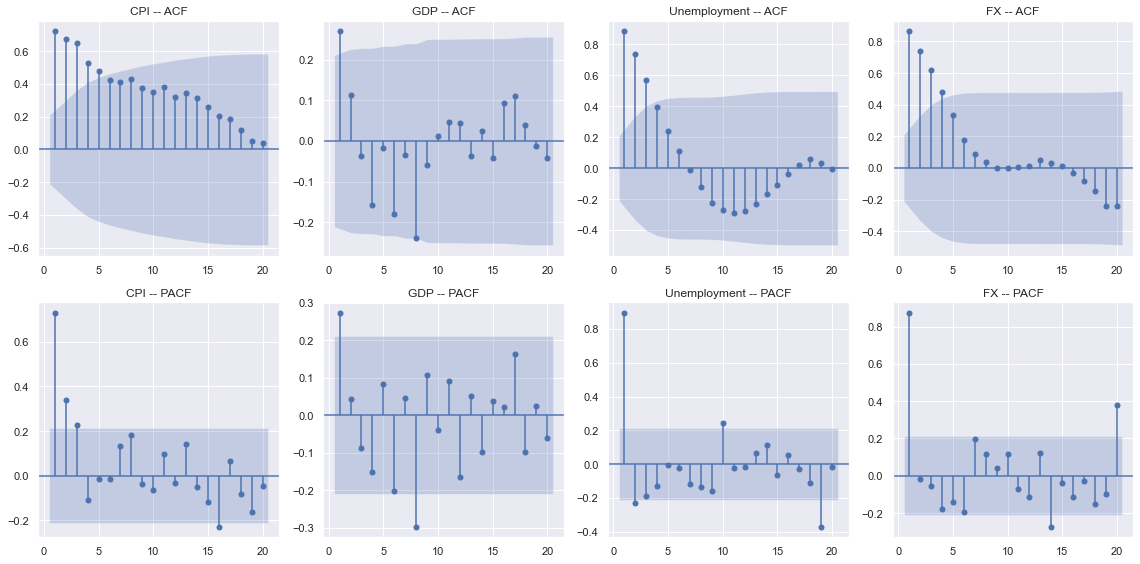

In [7]:
fig, axes = plt.subplots(nrows=2, 
                         ncols=4,
                         figsize=(16,8),
                         sharex=False)

plot_acf(data['cpi'],
         ax=axes[0][0],
         title='CPI -- ACF',
         zero=False)
plot_pacf(data['cpi'],
          ax=axes[1][0],
         title='CPI -- PACF',
         zero=False)

plot_acf(data['gdp'],
         ax=axes[0][1],
         title='GDP -- ACF',
         zero=False)
plot_pacf(data['gdp'],
          ax=axes[1][1],
          title='GDP -- PACF',
         zero=False)

plot_acf(data['unemployment'],
         ax=axes[0][2],
         title='Unemployment -- ACF',
         zero=False)
plot_pacf(data['unemployment'],
          ax=axes[1][2],
         title='Unemployment -- PACF',
         zero=False)

plot_acf(data['fx'],
         ax=axes[0][3],
         title='FX -- ACF',
         zero=False)
plot_pacf(data['fx'],
          ax=axes[1][3],
         title='FX -- PACF',
         zero=False)

#axes.set_xlabel('')

#handles, labels = axes[0][0].get_legend_handles_labels()
#fig.legend(handles, 
#           labels,
#           loc='lower center',
#           ncol=2)

plt.tight_layout()
#plt.subplots_adjust(top=0.925)
#plt.subplots_adjust(bottom=0.175)

plt.savefig(directory_figures+'q5a.png',
            bbox_inches='tight',
            dpi=150)

## 3. 5c and 5d Using BIC, choose a parsimonious parametric AR(p) model. Report the values of BIC for p=0,...,10. Conduct the diagnostic checking of the estimated optimal AR model: serial correlation of residuals (e.g., Box-Ljung; you may get the code for it at http://ideas.repec.org/c/boc/bocode/t961403.html); ACF/PACF for estimated residuals; normality of the error term (Jarque-Bera test; “jbtest” in Matlab).

In [8]:
## Very python way of doing this
results = pd.DataFrame({'variable':sum([[x]*10 for x in vars],[]),
                        'p':[x for x in range(1,11)]*len(vars)})
def get_X(variable,p):
    this_X = ['const']+[variable+'_l'+str(x) for x in range(1,p+1)]
    return(this_X)
results['X'] = results.apply(lambda x:
                             get_X(variable=x['variable'],
                                   p=x['p']),
                             axis=1)

In [9]:
## Get BIC and Jarque-era
def get_model_fit(y,X):
    this_reg = sm.OLS(endog=data[y],
                      exog=sm.add_constant(data[X]),
                      missing='drop')\
               .fit()
    this_bic = this_reg.bic
    this_jb_stat,this_jb_p = sms.jarque_bera(this_reg.resid)[:2]
    return(pd.Series([this_bic,this_jb_stat,this_jb_p]))
results[['bic','jb_stat','jb_p']] = results.apply(lambda x:
                                                get_model_fit(y=x['variable'],
                                                              X=x['X']),
                                                axis=1)                                            

In [10]:
results

,variable,p,X,bic,jb_stat,jb_p
0,cpi,1,"[const, cpi_l1]",166.356396,996.859355,3.425638e-217
1,cpi,2,"[const, cpi_l1, cpi_l2]",165.979419,1150.200171,1.726658e-250
2,cpi,3,"[const, cpi_l1, cpi_l2, cpi_l3]",160.431282,1504.295561,0.000000e+00
3,cpi,4,"[const, cpi_l1, cpi_l2, cpi_l3, cpi_l4]",162.042695,1637.276325,0.000000e+00
4,cpi,5,"[const, cpi_l1, cpi_l2, cpi_l3, cpi_l4, cpi_l5]",164.474672,1400.922973,6.215006e-305
5,cpi,6,"[const, cpi_l1, cpi_l2, cpi_l3, cpi_l4, cpi_l5...",168.927818,1393.829679,2.156408e-303
6,cpi,7,"[const, cpi_l1, cpi_l2, cpi_l3, cpi_l4, cpi_l5...",172.690517,1345.235349,7.688745e-293
7,cpi,8,"[const, cpi_l1, cpi_l2, cpi_l3, cpi_l4, cpi_l5...",175.934588,854.551744,2.731785e-186
8,cpi,9,"[const, cpi_l1, cpi_l2, cpi_l3, cpi_l4, cpi_l5...",179.890021,716.780276,2.254969e-156
9,cpi,10,"[const, cpi_l1, cpi_l2, cpi_l3, cpi_l4, cpi_l5...",183.364566,673.312228,6.195942e-147


In [37]:
#results[['variable','p','bic']].round(2).T.to_clipboard()
results.round(2).T.to_clipboard()

## 4. 5e and f Estimate the model using 1, ... , T-10 observations and compute point forecasts and forecast errors for 𝑇-9, ... , 𝑇 (for now, ignore sampling uncertainty in parameter estimates). Estimate the same model using 𝑇-50, ... , 𝑇-10 observations and compute point forecasts and forecast errors for 𝑇-9,...,𝑇 (for now, ignore sampling uncertainty in parameter estimates). Compare with forecasts and forecast errors in e). Discuss.

In [11]:
## Split sample
data_train_e = data.iloc[:-10].copy()
data_train_f = data.iloc[-50:-10].copy()
data_test = data.iloc[-10:].copy()

In [12]:
## Do forecasts
def get_forecast(data_train,data_test,y,X):

    ## Training regression
    reg_train = sm.OLS(endog=data_train[y],
                       exog=data_train[X],
                       missing='drop')\
                .fit()
    b_train = reg_train.params

    ## Point forecasts and forecast errors
    yhat_test = np.dot(b_train,data_test[X].T)
    e_test = data_test[y] - yhat_test
    rmse_test = np.sqrt(np.mean(np.square(e_test)))

    ## Out
    d_out = {'e_test':e_test,
             'yhat_test':yhat_test,
             'rmse_test':rmse_test}
    return(d_out)

results['forecast_e'] = results.apply(lambda x:
                                    get_forecast(data_train=data_train_e,
                                                 data_test=data_test,
                                                 y=x['variable'],
                                                 X=x['X']),
                                    axis=1)
results['forecast_f'] = results.apply(lambda x:
                                    get_forecast(data_train=data_train_f,
                                                 data_test=data_test,
                                                 y=x['variable'],
                                                 X=x['X']),
                                    axis=1)

In [22]:
## Keep best model by BIC
results_best = results.sort_values(['variable','bic'],
                                   ascending=True)\
                      .drop_duplicates(subset=['variable'])    

In [23]:
results_best

,variable,p,X,bic,jb_stat,jb_p,forecast_e,forecast_f
2,cpi,3,"[const, cpi_l1, cpi_l2, cpi_l3]",160.431282,1504.295561,0.000000e+00,"{'e_test': [-0.0986995052234127, 0.22499113337...","{'e_test': [-0.433967264655323, 0.014413845947..."
30,fx,1,"[const, fx_l1]",-173.914988,31.296275,1.599927e-07,"{'e_test': [0.07499330351924849, 0.01128450313...","{'e_test': [0.07661008103018574, 0.00336284162..."
10,gdp,1,"[const, gdp_l1]",208.389713,84.422756,4.654055e-19,"{'e_test': [0.14683807661767212, 0.39757533853...","{'e_test': [0.1653406039603852, 0.417971158844..."
21,unemployment,2,"[const, unemployment_l1, unemployment_l2]",-1.997559,12.614905,1.822671e-03,"{'e_test': [-0.06458833895304306, -0.297000086...","{'e_test': [-0.053580819229264165, -0.24374608..."


In [87]:
## Get forecast and forecast errors
yhat_test_e = [results_best['forecast_e'].iloc[i]['yhat_test'] for i in range(0,len(results_best))]
yhat_test_f = [results_best['forecast_f'].iloc[i]['yhat_test'] for i in range(0,len(results_best))]

e_test_e = [results_best['forecast_e'].iloc[i]['e_test'] for i in range(0,len(results_best))]
e_test_f = [results_best['forecast_f'].iloc[i]['e_test'] for i in range(0,len(results_best))]

yhat_test_e = pd.DataFrame(yhat_test_e,
                           index=results_best['variable']).T
e_test_e = pd.DataFrame(e_test_e,
                        index=results_best['variable']).T
yhat_test_f = pd.DataFrame(yhat_test_f,
                           index=results_best['variable']).T
e_test_f = pd.DataFrame(e_test_f,
                        index=results_best['variable']).T

test_e = pd.concat([yhat_test_e.reset_index(drop=True).add_suffix('_yhat'),
                    e_test_e.reset_index(drop=True).add_suffix('_e')],
                    axis=1)
test_f = pd.concat([yhat_test_f.reset_index(drop=True).add_suffix('_yhat'),
                    e_test_f.reset_index(drop=True).add_suffix('_e')],
                    axis=1)

In [93]:
## Out
test_e.to_csv(directory_cleandata+'q5e.txt',
              index=False,
              header=False)
test_f.to_csv(directory_cleandata+'q5f.txt',
              index=False,
              header=False)

In [94]:
test_e

variable,cpi_yhat,fx_yhat,gdp_yhat,unemployment_yhat,cpi_e,fx_e,gdp_e,unemployment_e
0,0.468467,1.531507,0.564333,6.997922,-0.098700,0.074993,0.146838,-0.064588
1,0.554183,1.326815,0.542824,4.463667,0.224991,0.011285,0.397575,-0.297000
2,0.467557,1.355183,0.608459,4.221746,0.309907,0.044917,0.154395,-0.188413
3,0.604630,1.415415,0.555789,4.118876,0.020756,-0.066965,0.278121,-0.185542
4,0.672632,1.365238,0.576869,4.047120,-0.267162,-0.053238,-0.094916,-0.280453
5,0.552594,1.329827,0.472459,3.848373,-0.161869,-0.029527,-0.249317,-0.015040
6,0.475832,1.318461,0.395682,4.061712,-0.298705,-0.002661,0.202109,-0.195046
7,0.243328,1.333519,0.506823,4.071240,0.620728,-0.021769,0.286102,-0.471240
8,0.635417,1.329584,0.564710,3.628040,-0.314972,-0.090134,0.120789,0.005294
9,0.190391,1.259346,0.532842,3.853439,0.460684,0.000254,-0.063744,-0.253439


In [95]:
test_f

variable,cpi_yhat,fx_yhat,gdp_yhat,unemployment_yhat,cpi_e,fx_e,gdp_e,unemployment_e
0,0.803734,1.529890,0.545830,6.986914,-0.433967,0.076610,0.165341,-0.053581
1,0.764760,1.334737,0.522429,4.410413,0.014414,0.003363,0.417971,-0.243746
2,0.565412,1.361783,0.593841,4.157805,0.212052,0.038317,0.169013,-0.124472
3,0.523398,1.419208,0.536535,4.054163,0.101988,-0.070758,0.297376,-0.120830
4,0.587605,1.371369,0.559470,3.982292,-0.182135,-0.059369,-0.077517,-0.215625
5,0.646201,1.337608,0.445869,3.776562,-0.255476,-0.037308,-0.222727,0.056771
6,0.688669,1.326772,0.362334,4.004176,-0.511543,-0.010972,0.235457,-0.137509
7,0.663005,1.341128,0.483258,4.012507,0.201051,-0.029378,0.309667,-0.412507
8,0.695029,1.337377,0.546241,3.547394,-0.374583,-0.097927,0.139258,0.085939
9,0.463526,1.270412,0.511567,3.790115,0.187549,-0.010812,-0.042470,-0.190115


In [ ]:
## RMSE

In [ ]:
## CPI

In [38]:
results_best.iloc[0]['forecast_e']['rmse_test']

0.32254900349335425

In [39]:
results_best.iloc[0]['forecast_f']['rmse_test']

0.2863439230335233

In [ ]:
## FX

In [40]:
results_best.iloc[1]['forecast_e']['rmse_test']

0.04956253153727595

In [41]:
results_best.iloc[1]['forecast_f']['rmse_test']

0.05287898664226258

In [ ]:
## GDP

In [42]:
results_best.iloc[2]['forecast_e']['rmse_test']

0.22211265770402422

In [43]:
results_best.iloc[2]['forecast_f']['rmse_test']

0.23391911347464509

In [ ]:
## Unemployment

In [44]:
results_best.iloc[3]['forecast_e']['rmse_test']

0.23781397336838084

In [45]:
results_best.iloc[3]['forecast_f']['rmse_test']

0.19356998845914122